# Sentiment analysis with LSTM model

In this notebook, we are focusing on the task of training a Long Short-Term Memory (LSTM) model. The purpose is to predict sentiment related to a specific aspect, namely, business cycle conditions. We use a dataset provided by MediaTenor to train our model. Once trained, the model will then be used to predict the sentiment on business cycle conditions as expressed in Süddeutsche Zeitung, Handelsblatt, Welt, and dpa.

We again use segments of code from the Udacity Deep Learning Specialization for the training of our LSTM model. It should be noted that such usage aligns with the permissions granted by the MIT License associated with the original source code.

---

## Data Loading and Pre-processing

In this step, we begin by importing the articles that have been previously annotated by MediaTenor, along with their corresponding labels. It's important to clarify how these labels are categorized: the label "negative" is attributed to articles that were classified as having a negative sentiment. However, the "positive" label is used not only for articles with positive sentiment but also for those deemed to have no clear tone.

In [1]:
import numpy as np

# Open and read articles from the 'articles.txt' file 
with open('MediaTenor_data/articles.txt', 'r', encoding = 'utf-8') as f:
    articles = f.read().strip()

# Open and read labels from the 'labels_binary.txt' file    
with open('MediaTenor_data/labels_binary.txt', 'r', encoding = 'utf-8') as f:
    labels = f.read().strip()

In [2]:
# Print the first 1000 characters of the articles content
print(articles[:1000])
print()

# Print the first 20 characters of the labels content
print(labels[:20])

SPIEGEL-Gespräch mit Expräsident Lula da Silva über Korruptionsvorwürfe und seine Nachfolgerin Dilma Rousseff. Der ehemalige brasilianische Präsident Luiz Inácio Lula da Silva, 70, spricht über die Krise in seinem Land, wehrt sich gegen Korruptionsvorwürfe und verteidigt seine Nachfolgerin Dilma Rousseff. SPIEGEL: Herr Präsident, in einem Monat beginnen in Rio de Janeiro die Olympischen Spiele, aber das Land befindet sich in einer schweren politischen und wirtschaftlichen Krise. Als Brasilien den Zuschlag bekam, galt es als kommender Star unter den Schwellenländern. Wie konnte es zu diesem Absturz kommen? Lula: Als ich die Olympischen Spiele und die Fußballweltmeisterschaft nach Brasilien geholt habe, glaubte ich tatsächlich, wir würden uns bis 2016 im Kreis der fünf oder sechs größten Wirtschaftsmächte etablieren. Aber wir leiden noch immer unter einer weltweiten Finanzkrise. Die USA haben sich nicht wirklich erholt, Europa steckt weiter in der Krise, Chinas Wirtschaftsleistung geht z

After loading the annotated articles, we proceed to a focused text pre-processing step. Since our goal is to predict sentiment related to business cycle conditions, we retain only those sentences that are directly relevant to the economy or business cycle. This helps improve the accuracy of our sentiment prediction model, as not all parts of each article may be relevant to the classification.

In [3]:
import os
import multiprocessing as mp 
from datetime import datetime
from functools import partial
import keep_economy_related_sentences

NUM_CORE = 60 # set the number of cores to use

# Set the path variable to point to the 'word_embeddings' directory.
path = os.getcwd().replace('\\sentiment', '') + '\\word_embeddings'

# Load words related to 'Wirtschaft' and 'Konjunktur'
konjunktur_words = keep_economy_related_sentences.load_words(path + '\\konjunktur_synonyms.txt')
wirtschaft_words = keep_economy_related_sentences.load_words(path + '\\wirtschaft_synonyms.txt')

# Combine the two lists
economy_related_words = konjunktur_words + wirtschaft_words

startTime = datetime.now() 

if __name__ == "__main__":
    pool = mp.Pool(NUM_CORE)
    inputs = zip(articles.split('\n'), [economy_related_words]*len(articles.split('\n')))
    economy_related_sentences = pool.starmap(keep_economy_related_sentences.keep_economy_related_sentences, inputs) 
    pool.close()
    pool.join()
    
print(datetime.now()-startTime)

print(economy_related_sentences[0])

0:00:39.065097
SPIEGEL: Herr Präsident, in einem Monat beginnen in Rio de Janeiro die Olympischen Spiele, aber das Land befindet sich in einer schweren politischen und wirtschaftlichen Krise. Die USA haben sich nicht wirklich erholt, Europa steckt weiter in der Krise, Chinas Wirtschaftsleistung geht zurück. Lula: Ich habe Dilma immer gesagt: Du redest zu viel mit Ökonomen, wir brauchen mehr Politik. Es ist möglich, dass viele von euch ihren Job verlieren, aber wenn ihr jetzt Angst habt und nicht mehr konsumiert, dann steigt die Arbeitslosigkeit erst recht. Lula: Ich denke, man muss die Dinge im Zusammenhang sehen: der wirtschaftliche Abschwung, der knappe Ausgang der letzten Wahlen, das vergiftete Klima in einer immer stärker polarisierten Gesellschaft. Viel mehr Sorgen bereitet mir, dass es in unserer Demokratie offenbar möglich ist, ein Opfer solcher Lügen zu werden.


In [4]:
# Initialize an empty string to store the segments of articles related to economy
articles = ''

for article in economy_related_sentences:
    articles = articles + article + ' \n'

To prepare our dataset for the LSTM model, we follow several standard pre-processing steps. These steps include transforming all characters to lowercase, removing URLs, removing all punctuation and non-alphabetic characters, consolidating multiple whitespaces into a single one, eliminating single-letter tokens from the text, and excluding metadata from the articles. Lastly, we exclude any words that do not have a corresponding embedding in our pre-trained word2vec model. This ensures that our LSTM model will only be trained on words for which we have a pre-existing, rich representation, which improves the model's overall effectiveness.

In [5]:
import re
import remove_words_without_embeddings
import csv
from string import punctuation

def remove_multiple_spaces(text):
    """
    This function removes multiple spaces in a string. 
    It uses a regular expression to match 2 or more spaces and replaces them with a single space.
    """
    text = re.sub(r'\s{2,}', ' ', text)
    return text

def remove_short_words(text):
    """
    This function removes words of length 1 from a string.
    """
    text = ' '.join([word for word in text.split() if len(word) > 1])
    return text

def remove_metadata(text, meta_list):
    """
    This function removes metadata from a text.
    Metadata is a list of phrases. If any of these phrases are found in the text,
    everything from the phrase and onwards is cut off.
    """
    for phrase in meta_list:
        if phrase in text:
            text = text.split('dokument', 1)[0]
    return text

# List of metadata phrases
metadata_phrases = ['dokument bihann', 'dokument bid', 'dokument welt', 'dokument bberbr', 'dokument focus']

# Convert articles to lowercase
articles = articles.lower()

# Remove URLs
articles = re.sub(r'https\S+|http\S+|www.\S+', '', articles)

# Remove punctuation
articles = articles.replace('.', ' ').replace('-', ' ').replace('/', ' ')
articles = ''.join([c for c in articles if c not in punctuation and c not in ['»', '«']])

# Remove non-alphabetic characters from the text
articles = ''.join([c for c in articles if (c.isalpha() or c in [' ', '\n'])])

# Split articles by new lines
articles_split = articles.split('\n')[:-1]

# Remove multiple spaces, single-letter tokens, and metadata
articles_split = list(map(remove_multiple_spaces, articles_split))
articles_split = list(map(remove_short_words, articles_split))
articles_split = list(map(lambda text: remove_metadata(text, metadata_phrases), articles_split))

# Load list of words that do not have embeddings
with open('words_without_pretrained_vector.csv', newline='', encoding='utf-8-sig') as f:
    reader = csv.reader(f)
    words_without_embeddings = [word for sublist in reader for word in sublist]

# Remove words that do not have embeddings
startTime = datetime.now() 

if __name__ == "__main__":
    pool = mp.Pool(NUM_CORE)
    articles_split = pool.starmap(remove_words_without_embeddings.remove_words_without_embeddings, [(text, words_without_embeddings) for text in articles_split]) 
    pool.close()
    pool.join()
    
print(datetime.now()-startTime)

# Join all articles into a single string
all_text = ' '.join(articles_split)

# Create a list of all words in the MediaTenor data
words = all_text.split()

0:00:08.398392


Now, we generate a dictionary that maps each unique word in the articles to a unique integer, and then convert the text in each article to a list of corresponding integer tokens.

In [6]:
from collections import Counter

# Count the occurrences of each word in the articles
word_counts = Counter(words)

# Sort words by their count, in descending order
sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)

# Create a dictionary that maps each word to a unique integer
# Reserved 0 for padding and 1 for unknown words
vocab_to_int = {word: idx for idx, word in enumerate(sorted_vocab, 2)}
vocab_to_int['<pad>'] = 0
vocab_to_int['<unk>'] = 1

# Convert each article to a list of integers (tokens)
articles_ints = [[vocab_to_int[word] for word in article.split()] for article in articles_split]

# Print the total number of unique words
print('Unique words: ', len((vocab_to_int)))
print()

# Print the tokenized version of the first article in our dataset
print('Tokenized article: \n', articles_ints[:1])

Unique words:  29242

Tokenized article: 
 [[90, 648, 174, 5, 57, 663, 2313, 5, 7248, 1065, 9429, 2, 5977, 5107, 33, 6, 70, 952, 13, 5, 42, 1470, 267, 4, 89, 86, 2, 93, 43, 13, 15, 455, 1149, 97, 826, 122, 5, 3, 86, 227, 130, 129, 365, 3580, 95, 211, 5108, 74, 1066, 1702, 9430, 8, 111, 17, 78, 31, 366, 37, 124, 14, 11, 483, 19, 85, 12, 3270, 218, 777, 653, 33, 47, 175, 120, 559, 7249, 4, 15, 37, 5978, 100, 348, 2, 103, 219, 438, 3580, 95, 2192, 87, 107, 2, 1471, 20, 2077, 284, 3, 76, 698, 3, 5109, 2622, 3, 357, 1877, 6, 9431, 1643, 5, 42, 74, 65, 9432, 345, 111, 37, 58, 1067, 419, 19, 14, 5, 325, 757, 1022, 483, 11, 21, 2078, 1644, 4447, 8, 48]]


## Embedding Matrix Initialization

This part of the code initializes an embedding matrix, word2vec, with random values for each unique word in the vocabulary. The embedding matrix is a 2D numpy array where each row corresponds to a unique word's embedding. If a pre-trained embedding for a word exists, this pre-trained vector is loaded into the corresponding row in the word2vec matrix. The purpose of this embedding matrix is to provide dense vector representations of words for the LSTM model's embedding layer, which will be used during training to better capture the semantics and context of the words in the articles.

In [7]:
import torch
# Initialize word vectors with random values
# Dimension of word vectors is 256
word2vec = np.random.uniform(-0.25, 0.25, (len(vocab_to_int), 256))

# Set vector for padding to all zeros
word2vec[0] = np.zeros((256,))

# Load pre-trained word vectors
with open(path + '\\news_word2vec.txt', 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
    pretrained_vectors_found = 0
    for line in f:
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in vocab_to_int:
            pretrained_vectors_found += 1
            word2vec[vocab_to_int[word]] = np.array(tokens[1:], dtype=np.float32)
    print(f"There are {pretrained_vectors_found} / {len(vocab_to_int)} pretrained vectors found.")

# Convert the word2vec numpy array into a PyTorch tensor    
word2vec = torch.tensor(word2vec)

There are 29239 / 29242 pretrained vectors found.


## Label Encoding

Our labels are either "positive" (which includes positive or no clear tone sentiment) or "negative". To facilitate their use within our neural network, we need to convert these categorical labels into numerical form, specifically 0 and 1.

In [8]:
# Convert labels to binary format: 1 for 'positive' and 0 for 'negative'
labels_split = labels.split('\n')
encoded_labels = np.array([1 if label == 'positive' else 0 for label in labels_split])

## Removing Outliers

In preparation for model training, it's important to standardize the length of our articles. This is because our network requires a fixed size of input. Therefore, to prevent training issues caused by length outliers, we remove any articles composed of 20 characters or fewer. Since our focus is on business cycle and the economy, articles of such short length likely don't contribute much sentiment about these topics, justifying their exclusion.

In [9]:
# Get the number of articles before removing outliers and print it
num_articles_before = len(articles_ints)
print('Number of articles before removing outliers: ', num_articles_before)

# Get the indices of articles which have more than 20 tokens
valid_article_indices = [idx for idx, article in enumerate(articles_ints) if len(article) > 20]

# Use the indices to filter our articles and labels, removing articles with 20 or fewer tokens
articles_ints = [articles_ints[idx] for idx in valid_article_indices]
encoded_labels = np.array([encoded_labels[idx] for idx in valid_article_indices])

# Print the number of articles after removing short ones
num_articles_after = len(articles_ints)
print('Number of articles after removing outliers: ', num_articles_after)

Number of articles before removing outliers:  3286
Number of articles after removing outliers:  2433


## Padding sequences

To manage the variability in article lengths, we'll standardize all articles to a fixed length, `seq_length` of 200 words. For shorter articles that do not meet this length, we'll supplement them with 0s (known as padding). On the other hand, for articles that exceed the `seq_length`, we'll truncate them to only include the first 200 words. This ensures uniformity in the input size for our model, enabling it to handle both short and long articles effectively.

In [10]:
def pad_features(articles_ints, seq_length):
    ''' 
    Return features of articles_ints, where each article is either padded with 0's 
    or truncated to match the input seq_length.
    '''
    
    # Initialize a 2D numpy array of zeros with shape (len(articles_ints) x seq_length)
    features = np.zeros((len(articles_ints), seq_length), dtype=int)

    # Process each article: if the article is shorter than seq_length, pad it with zeros; 
    # if the article is longer than seq_length, truncate it to fit the desired size
    for i, row in enumerate(articles_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features

In [11]:
# Set a fixed sequence length
seq_length = 200

# Pad or truncate the article sequences to a fixed sequence length
features = pad_features(articles_ints, seq_length=seq_length)

# Make sure the features 2D array has as many rows as the number of articles
assert len(features)==len(articles_ints), "Your features should have as many rows as articles."
# Make sure each row in the features 2D array has length equal to seq_length
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."

# Print the first 10 values of the first 30 articles after padding/truncating
print(features[:30,:10])

[[    0     0     0     0     0     0     0     0     0     0]
 [    6  1098    67  1150 13775     3  7250   126     3   105]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [13794   133    17   154  3584  5989     2    76   851     4]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0

## Training, Validation, Test

With our data in nice shape, we'll split it into training, validation, and test sets.

In [12]:
# Split features (X) and encoded labels (y) into training and remaining datasets
# The training dataset contains about 80% of the data and the remaining dataset contains about 20%
split_idx = 1920
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

# Now we want to split the remaining data into validation and test datasets
# Here, we'll use about 10% of the remaining data for the test dataset, and the rest will go into the validation dataset
# We leave out the last article because it won't form a full batch later when we use a batch size of 32
test_idx = 256
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:-1]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:-1]

# Print out the shapes of your final datasets
# This is to confirm that the datasets were split as expected
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(1920, 200) 
Validation set: 	(256, 200) 
Test set: 		(256, 200)


## DataLoaders and Batching

After creating our training, test, and validation datasets, we construct DataLoaders in two main steps:

First, we format the data using PyTorch's [TensorDataset](https://pytorch.org/docs/stable/data.html#) class, which combines the input and target datasets (both of which must have the same first dimension) into a single dataset.

Next, we create DataLoaders for the training, validation, and test datasets. The DataLoader class batches the data into manageable sizes for efficient processing and provides an iterable, making it easier to handle data during model training.

In [13]:
from torch.utils.data import TensorDataset, DataLoader

# Create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# Dataloaders are used to load data in batches, which is more efficient than loading all data at once
batch_size = 32

# Shuffling the data is important to prevent the model from learning the order of the training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [14]:
# Save the train DataLoader as a PyTorch file
# This allows us to quickly load this data for training
torch.save(train_loader, 'train_loader.pth')

# Save the validation DataLoader as a PyTorch file
# This allows us to quickly load this data for model validation during training
torch.save(valid_loader, 'valid_loader.pth')

# Save the test DataLoader as a PyTorch file
# This allows us to quickly load this data for model testing after training
torch.save(test_loader, 'test_loader.pth')

In [15]:
# Load the train DataLoader from a PyTorch file
# This allows us to quickly use the already pre-processed and batched data for training
#train_loader = torch.load('train_loader.pth')

# Load the validation DataLoader from a PyTorch file
# This allows us to quickly use the already pre-processed and batched data for model validation during training
#valid_loader = torch.load('valid_loader.pth')

# Load the test DataLoader from a PyTorch file
# This allows us to quickly use the already pre-processed and batched data for model testing after training
#test_loader = torch.load('test_loader.pth')

In [16]:
# Create an iterator from the DataLoader; this allows us to retrieve batches of data
dataiter = iter(train_loader)

# Get the next batch of data. Each batch consists of 'batch_size' articles and their corresponding labels.
# The articles are represented as sequences of integers of length 'seq_length'.
sample_x, sample_y = dataiter.next()

# Display the size and content of the sample inputs
# 'sample_x' is a tensor of shape (batch_size, seq_length), holding the articles
print('Sample input size: ', sample_x.size())
print('Sample input: \n', sample_x)
print()

# Display the size and content of the sample labels
# 'sample_y' is a tensor of shape (batch_size,), holding the labels for the articles
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([32, 200])
Sample input: 
 tensor([[    0,     0,     0,  ...,  1024,     8,   418],
        [   26,   426,    24,  ...,    95,   211,    24],
        [    0,     0,     0,  ...,    42,  1205,    35],
        ...,
        [    0,     0,     0,  ...,  3405,   392,   669],
        [    0,     0,     0,  ..., 18179,    20, 18180],
        [    0,     0,     0,  ...,    35,  2319,  2396]], dtype=torch.int32)

Sample label size:  torch.Size([32])
Sample label: 
 tensor([0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 1, 1], dtype=torch.int32)


## Sentiment Network with PyTorch

The layers are as follows:
1. An [embedding layer](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) that converts our word tokens (integers) into embeddings of a specific size.
2. An [LSTM layer](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) defined by a hidden_state size and number of layers
3. A fully-connected output layer that maps the LSTM layer outputs to a desired output_size

**Embedding layer:** The model uses a pre-trained embedding (word2vec) that converts our word tokens (integers) into embeddings of a specific size (256 in this case). Using pre-trained embeddings can help to improve the performance of the model because they have been trained on a large corpus and captured the semantic relationships between words. The embeddings are frozen during training, meaning they are not updated in the backpropagation process. This is often done when the pre-trained embeddings are considered to already contain good information, and we do not want to modify them too much. Keeping them frozen can also make the training process faster.

**LSTM layer:** The LSTM layer processes sequences of 200 elements as input, but instead of handling the entire sequence at once, it processes them in chunks of 100 elements. This technique, known as truncated backpropagation through time (TBTT), helps address the issue of long-term dependencies, where information from earlier in the sequence may lose significance or become computationally expensive to retain over time. By shortening the sequence length, the model can efficiently capture important temporal patterns without the computational burden of processing very long sequences.

**Dropout:** Dropout layers are applied after the LSTM layers and before the fully-connected layer. This regularization technique helps prevent overfitting by randomly setting 50% of the input elements to zero during training. By doing so, the network is encouraged to learn multiple representations of the data, making it more robust and better at generalizing to new, unseen data.

**Hidden units:** The LSTM layers contain 32 units each. The number of units in the LSTM layers indicates the capacity of the model. With more units, the model has a larger memory capacity and can model complex patterns.

**Optimizer and Loss:** The Adam optimizer is used for training the network, which is a popular choice because it combines the advantages of two other extensions of stochastic gradient descent: AdaGrad and RMSProp. The learning rate is set to a small value (0.0001), ensuring that the network learns slowly and converges well. The loss function is binary cross entropy loss as this is a binary classification problem.

**Class weights:** In this model, equal weights are assigned to each class. This approach is chosen because the data is relatively balanced, and we want to treat false positives and false negatives equally. By giving equal weights to each class, we ensure that the model does not favor any particular class, keeping its predictions unbiased.

**Output layer:** Finally, a fully-connected output layer maps the LSTM layer outputs to a desired output_size. In this case, the output_size is 1 because this is a binary classification problem, so we want to output a single probability score. A sigmoid activation function is used to ensure this output is between 0 and 1.

In [17]:
# Checking if GPU is available for training
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [18]:
def split_batch(seq_batch, bptt):
    """
    Function to split the sequence batch into smaller chunks based on a provided 
    backpropagation through time (bptt) step value. This helps in avoiding long
    sequence lengths which can lead to memory constraints.
    """
    batch_splits = seq_batch.split(bptt,dim=0)
    return batch_splits

In [19]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, pretrained_embedding, freeze_embedding, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        
        # Embedding layer: this layer takes the integer-encoded vocabulary and 
        # looks up the embedding vector for each word-token
        # If we have pre-trained embeddings, we use them, otherwise we initialize random embeddings
        if pretrained_embedding is not None:
            self.vocab_size, self.embedding_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding, freeze = freeze_embedding)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
            
        # LSTM layer: this layer takes in word embeddings, applies dropout 
        # regularization and gives hidden states as output      
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # Dropout layer: applies dropout to the output of LSTM layer 
        self.dropout = nn.Dropout(0.5)
        
        # Linear and Sigmoid layer: first, the output from LSTM layer is passed
        # through a Fully Connected layer and then it is passed through the 
        # sigmoid activation function. The output is a value between 0 and 1.
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # Convert input to appropriate type and pass input x through the embedding layer
        x = x.long()
        embeds = self.embedding(x).float()
        # Pass embeddings and hidden state into LSTM
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # Reshape lstm output for dropout and fully connected layer
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # Dropout and fully-connected layers
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # Sigmoid function to squash output between 0 and 1
        sig_out = self.sig(out)
        
        # Reshape output to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # Return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' 
        Initializes hidden state 
        '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda().float(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda().float())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().float(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().float())
        
        return hidden      

## Instantiate the Network

In this step, we'll initialize our network. We will first define the hyperparameters:

* `vocab_size`: This represents the size of our vocabulary. 
* `output_size`: This is the size of our desired output. For binary classification (positive or no clear tone/negative sentiment), the output size will be 1.
* `embedding_dim`: This is the size of our word embeddings. 
* `hidden_dim`: This is the number of units in the hidden layers of our LSTM cells. More units make the model more powerful and able to learn complex patterns, but it also increases computational complexity.
* `n_layers`: This represents the number of LSTM layers in the network. Adding multiple LSTM layers can help the model capture more complex patterns, but it also increases computational demands.
* `pretrained_embeddings`: This matrix contains the pre-trained word embeddings. By using pre-trained embeddings, the model can leverage existing knowledge about word meanings, which can improve performance, especially when the dataset is too small to learn high-quality embeddings directly.
* `freeze_embedding`: This is a boolean variable (True/False) that, when set to True, keeps the pre-trained word embeddings fixed instead of allowing them to be updated during training. Freezing the embeddings can be beneficial when you trust your pre-trained embeddings and you have a small dataset, to avoid overfitting.

In [20]:
# Model hyperparameters
vocab_size = len(vocab_to_int)
output_size = 1
embedding_dim = 256
hidden_dim = 32
n_layers = 2
pretrained_embedding = word2vec
freeze_embedding = True

net = SentimentRNN(pretrained_embedding, freeze_embedding, vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(29242, 256)
  (lstm): LSTM(256, 32, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sig): Sigmoid()
)


The next step in our pipeline is to define the loss and optimization functions that our model will use for learning.

For our binary classification problem, we're using the Binary Cross Entropy Loss (nn.BCELoss). It measures the error between our model's predictions and the actual class labels. Here, we've set reduction='none' to compute the loss for each element of the output and target individually, rather than reducing the losses by taking their mean or sum.

In [21]:
# Defining loss and optimization functions
lr = 0.0001

criterion = nn.BCELoss(reduction='none')
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

## Training

In [22]:
# Training parameters

epochs = 40 
counter = 0
print_every = 60
clip = 5 # for gradient clipping

# Moving model to GPU, if available
if(train_on_gpu):
    net.cuda()
    
# Switching model to training mode
net.train()

# Training loop
for e in range(epochs):
    # Initializing hidden state
    h = net.init_hidden(batch_size)

    # Batch loop
    for inputs, labels in train_loader:
        counter += 1
        
        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # Zeroing accumulated gradients
        net.zero_grad()
                
        # Splitting the input text into chunks for the LSTM       
        for j in range(2):
            text_chunk = [split_batch(inputs[i], 100)[j] for i in range(batch_size)]
            text_chunk = torch.stack(text_chunk)
            
            if(train_on_gpu):
                text_chunk = text_chunk.cuda()
            
            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])
            
            # Zeroing accumulated gradients
            net.zero_grad()

            # Getting the output from the model
            output, h = net(text_chunk, h)

            # Calculating the loss and performing backprop
            weight = torch.tensor([0.5, 0.5])
            weight_ = weight[labels.float().data.view(-1).long()].view_as(labels.float())
            if(train_on_gpu):
                weight_ = weight_.cuda()
        
        
            loss = criterion(output.squeeze(), labels.float())
            loss_class_weighted = loss*weight_
            loss_class_weighted = loss_class_weighted.mean()

            
            loss_class_weighted.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem 
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()

        # Printing loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                weight = torch.tensor([0.5, 0.5])
                weight_ = weight[labels.float().data.view(-1).long()].view_as(labels.float())
                if(train_on_gpu):
                    weight_ = weight_.cuda()
                val_loss = criterion(output.squeeze(), labels.float())
                val_loss_weighted = val_loss*weight_
                val_loss_weighted = val_loss_weighted.mean()

                val_losses.append(val_loss_weighted.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss_class_weighted.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/40... Step: 60... Loss: 0.348326... Val Loss: 0.346670
Epoch: 2/40... Step: 120... Loss: 0.347248... Val Loss: 0.346352
Epoch: 3/40... Step: 180... Loss: 0.341885... Val Loss: 0.346130
Epoch: 4/40... Step: 240... Loss: 0.351973... Val Loss: 0.345795
Epoch: 5/40... Step: 300... Loss: 0.335948... Val Loss: 0.345360
Epoch: 6/40... Step: 360... Loss: 0.339921... Val Loss: 0.344469
Epoch: 7/40... Step: 420... Loss: 0.341735... Val Loss: 0.343177
Epoch: 8/40... Step: 480... Loss: 0.335304... Val Loss: 0.340599
Epoch: 9/40... Step: 540... Loss: 0.362464... Val Loss: 0.335247
Epoch: 10/40... Step: 600... Loss: 0.329681... Val Loss: 0.329693
Epoch: 11/40... Step: 660... Loss: 0.389076... Val Loss: 0.324682
Epoch: 12/40... Step: 720... Loss: 0.320897... Val Loss: 0.326543
Epoch: 13/40... Step: 780... Loss: 0.280078... Val Loss: 0.325827
Epoch: 14/40... Step: 840... Loss: 0.342921... Val Loss: 0.324156
Epoch: 15/40... Step: 900... Loss: 0.290134... Val Loss: 0.329679
Epoch: 16/40... Step

In [23]:
checkpoint = {'pretrained_embedding': word2vec,
              'freeze_embedding': True,
              'vocab_size': len(vocab_to_int),
              'output_size': 1,
              'embedding_dim': 256,
              'hidden_dim': 32,
              'n_layers': 2,
              'drop_prob':0.5,
              'batch_size': 32,
              'state_dict': net.state_dict()}

torch.save(checkpoint, 'lstm.pth')

In [24]:
#import torch

# Load the checkpoint
#checkpoint_loaded = torch.load('lstm.pth')

# Instantiate the SentimentRNN model with the parameters saved in the checkpoint
#net = SentimentRNN(checkpoint_loaded['pretrained_embedding'],
#                     checkpoint_loaded['freeze_embedding'],
#                     checkpoint_loaded['vocab_size'],
#                     checkpoint_loaded['output_size'],
#                     checkpoint_loaded['embedding_dim'],
#                     checkpoint_loaded['hidden_dim'],
#                     checkpoint_loaded['n_layers'],
#                     checkpoint_loaded['drop_prob'])

# Load the saved state dictionary into the model
#net.load_state_dict(checkpoint_loaded['state_dict'])

# Print the model's architecture
#print(net)

# If a GPU is available, move the model to GPU memory for faster computations
#if(train_on_gpu):
#    net.cuda()
    
# Specify the loss function
#criterion = nn.BCELoss(reduction='none')

# Specify the batch size for the DataLoader
#batch_size = 32

## Testing

* **Evaluating model performance on test data:** Now, let's assess how well our trained model performs on the test dataset. We'll look beyond accuracy and include metrics like the F1 score and class-specific performance. We'll also report the average loss, which helps us compare it to the training loss and see how well the model generalizes to new data.

In [25]:
import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_fscore_support

# Get test data loss and accuracy
test_losses = [] # Track loss
num_correct = 0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
class_preds = {i: [] for i in range(2)}  # Store predictions for each class for f1 calculation
class_true = {i: [] for i in range(2)}  # Store true labels for each class for f1 calculation


# Init hidden state
h = net.init_hidden(batch_size)

# Set the module in evaluation mode
net.eval()

# Iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # Get predicted outputs
    output, h = net(inputs, h)
    
    # Calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    weight = torch.tensor([0.5, 0.5])
    weight_ = weight[labels.float().data.view(-1).long()].view_as(labels.float())
    if(train_on_gpu):
        weight_ = weight_.cuda()
    test_loss_weighted = test_loss*weight_
    test_loss_weighted = test_loss_weighted.mean()
    test_losses.append(test_loss_weighted.item())

    # Convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # Rounds to the nearest integer
    
    # Compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
    
    # Append predictions and true labels for each class
    for i in range(batch_size):
        target = labels.data[i]
        class_correct[target] += correct[i].item()
        class_total[target] += 1
        class_preds[int(target.item())].append(pred[i].item())
        class_true[int(target.item())].append(target.item())

# -- Stats! -- ##
# Average test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# Accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

# Get all predictions and true labels
all_true = [val for sublist in class_true.values() for val in sublist]
all_preds = [val for sublist in class_preds.values() for val in sublist]

# Calculate precision, recall, f1-score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(all_true, all_preds, zero_division=1)

# Calculate and print f1-score and accuracy for each class
for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            i, 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
        print('F1 Score of %5s: %.2f' % (i, f1_score[i]))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
        
# Calculate and print the average f1-score over all classes
avg_f1_score = metrics.f1_score(all_true, all_preds, average='macro')
print("Average F1 Score: %.2f" % avg_f1_score)

Test loss: 0.323
Test accuracy: 0.668
Test Accuracy of     0: 62% (77/124)
F1 Score of     0: 0.64
Test Accuracy of     1: 71% (94/132)
F1 Score of     1: 0.69
Average F1 Score: 0.67


In [26]:
import pickle

# Save the vocab_to_int dictionary using the `pickle` module for future use 
with open('vocab_to_int.pickle', 'wb') as handle:
    pickle.dump(vocab_to_int, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Performing Inference on Main Corpus

We will now use a pre-trained LSTM model to predict the sentiment in our main corpus, which includes articles from Süddeutsche Zeitung, Handelsblatt, Welt, and dpa.

To proceed with our sentiment prediction task, we will follow these steps:

1. Load the data from our main corpus.

In [27]:
import pandas as pd
from ast import literal_eval

# Set the path variable to point to the 'newspaper_data_processing' directory, which is located in the same 
# parent directory as 'newspaper_analysis'. This is the repository used for data pre-processing.
path = os.getcwd().replace('\\newspaper_analysis\\sentiment', '') + '\\newspaper_data_processing'

# Load pre-processed 'dpa' dataset from a CSV file.
dpa = pd.read_csv(path + '\\dpa\\' + 'dpa_prepro_final.csv', encoding = 'utf-8', sep=';', index_col = 0,  keep_default_na=False,
                   dtype = {'rubrics': 'str', 
                            'source': 'str',
                            'keywords': 'str',
                            'title': 'str',
                            'city': 'str',
                            'genre': 'str',
                            'wordcount': 'str'},
                  converters = {'paragraphs': literal_eval})

# Keep only the article texts and their respective publication dates.
dpa = dpa[['texts', 'day', 'month', 'year']]

# Add 'source' column with value 'dpa' for all rows
dpa['source'] = 'dpa'

# Load pre-processed 'SZ' dataset from a CSV file.
sz = pd.read_csv(path + '\\SZ\\' + 'sz_prepro_final.csv', encoding = 'utf-8-sig', sep=';', index_col = 0, dtype = {'newspaper': 'str',
                                                                                                 'newspaper_2': 'str',
                                                                                                 'quelle_texts': 'str',
                                                                                                 'page': 'str',
                                                                                                 'rubrics': 'str'})
sz.page = sz.page.fillna('')
sz.newspaper = sz.newspaper.fillna('')
sz.newspaper_2 = sz.newspaper_2.fillna('')
sz.rubrics = sz.rubrics.fillna('')
sz.quelle_texts = sz.quelle_texts.fillna('')

# Keep only the article texts and their respective publication dates.
sz = sz[['texts', 'day', 'month', 'year']]

# Add 'source' column with value 'SZ' for all rows
sz['source'] = 'SZ'

# Load pre-processed 'Handelsblatt' dataset from a CSV file.
hb = pd.read_csv(path + '\\Handelsblatt\\' + 'hb_prepro_final.csv', encoding = 'utf-8-sig', sep=';', index_col = 0, dtype = {'kicker': 'str',
                                                                                                 'page': 'str',
                                                                                                 'series_title': 'str',
                                                                                                 'rubrics': 'str'})
hb.page = hb.page.fillna('')
hb.series_title = hb.series_title.fillna('')
hb.kicker = hb.kicker.fillna('')
hb.rubrics = hb.rubrics.fillna('')

# Keep only the article texts and their respective publication dates.
hb = hb[['texts', 'day', 'month', 'year']]

# Add 'source' column with value 'Handelsblatt' for all rows
hb['source'] = 'Handelsblatt'

# Load pre-processed 'Welt' dataset from a CSV file.
welt = pd.read_csv(path + '\\Welt\\' + 'welt_prepro_final.csv', encoding = 'utf-8-sig', sep=';', index_col = 0, dtype = {'newspaper': 'str',
                                                                                                 'rubrics': 'str',
                                                                                                 'title': 'str'})
welt.title = welt.title.fillna('')
welt.rubrics = welt.rubrics.fillna('')

# Keep only the article texts and their respective publication dates.
welt = welt[['texts', 'day', 'month', 'year']]

# Add 'source' column with value 'Welt' for all rows
welt['source'] = 'Welt'

# Concatenate the 'dpa', 'sz', 'hb', and 'welt' DataFrames into a single DataFrame 'data'.
data = pd.concat([dpa, sz, hb, welt])

# The number of articles in the final dataset.
print(len(data))

# Sort the data in chronological order.
data = data.sort_values(['year', 'month', 'day'], ascending=[True, True, True])
# Reset the index of the DataFrame
data.reset_index(inplace=True, drop=True)
data.head()

3336299


,texts,day,month,year,source
0,Schalck: Milliardenkredit sicherte Zahlungsfäh...,1,1,1991,dpa
1,Welajati: Iran bleibt bei einem Krieg am Golf ...,1,1,1991,dpa
2,Bush will offenbar seinen Außenminister erneut...,1,1,1991,dpa
3,Sperrfrist 1. Januar 1000 HBV fordert umfassen...,1,1,1991,dpa
4,Schamir weist Nahost-Äußerungen des neuen EG-P...,1,1,1991,dpa


2. Pre-process the data to match the format needed by our LSTM model for prediction.

In [28]:
from tokenize_test_data_multi import TokenizeTestDataMulti
from worker_keep_relevant_sentences import worker_keep_relevant_sentences
from worker_clean_test_data import worker_clean_test_data

# Set the path variable to point to the 'word_embeddings' directory.
path = os.getcwd().replace('\\sentiment', '') + '\\word_embeddings'

# Load words related to 'Wirtschaft' and 'Konjunktur'
konjunktur_words = keep_economy_related_sentences.load_words(path + '\\konjunktur_synonyms.txt')
wirtschaft_words = keep_economy_related_sentences.load_words(path + '\\wirtschaft_synonyms.txt')

# Combine the two lists
economy_related_words = konjunktur_words + wirtschaft_words

# Load list of words that do not have embeddings
with open('words_without_pretrained_vector.csv', newline='', encoding='utf-8-sig') as f:
    reader = csv.reader(f)
    words_without_embeddings = [word for sublist in reader for word in sublist]

# Set number of cores for multiprocessing
NUM_CORE = 60

startTime = datetime.now()

# Pre-process articles from the main corpus
if __name__ == "__main__":
    pool = mp.Pool(NUM_CORE)
    
    # Create TokenizeTestDataMulti objects for each article
    list_of_objects = [TokenizeTestDataMulti(text, economy_related_words, words_without_embeddings) for text in data.texts]
    
    # Filter out sentences that don't contain any economy-related words
    economy_related_sentences = pool.map(worker_keep_relevant_sentences, ((obj) for obj in list_of_objects))
    
    pool.close()
    pool.join()
    
    pool = mp.Pool(NUM_CORE)
    
    # Create new TokenizeTestDataMulti objects for the remaining sentences
    list_of_objects = [TokenizeTestDataMulti(text, economy_related_words, words_without_embeddings) for text in economy_related_sentences]
    
    # Clean the test data by applying the 'clean_test_data' method
    tokenized_articles = pool.map(worker_clean_test_data, ((obj) for obj in list_of_objects))
    
    pool.close()
    pool.join()
    
print(datetime.now() - startTime)

0:22:39.821888


In [29]:
import csv

with open("corpus_preprocessed_lstm.csv", "w", newline = "", encoding = "utf-8-sig") as f:
    writer = csv.writer(f)
    writer.writerows(tokenized_articles)

In [30]:
#from csv import reader

#with open('corpus_preprocessed_lstm.csv', 'r', encoding = "utf-8-sig") as read_obj:
#    csv_reader = reader(read_obj)
#    tokenized_articles = list(csv_reader)

3. Pass each pre-processed article from the main corpus through the LSTM model to produce sentiment predictions.

In [31]:
# Function to generate a sentiment prediction for a given test article
def predict(net, test_article, sequence_length=200):
    
    '''
    Function to generate a sentiment prediction for a given test article.
    
    Parameters:
    net: Trained neural network
    test_article: A tokenized list of words from a test article
    sequence_length: The sequence length the model was trained on.
    
    Returns:
    The sentiment prediction as a float (between 0 and 1)
    '''
    
    # Set the module in evaluation mode
    net.eval()
    
    # Convert article words to their corresponding integer values, if a word is not in the dictionary, 
    # use the integer for the special '<unk>' token
    test_ints = [[vocab_to_int.get(word, vocab_to_int['<unk>']) for word in test_article]]
    
    # Remove 'unknown' tokens (represented by 1) from the test article.
    test_ints = [[t for t in test_ints[0] if t!=1]]
    
    # If the article is less than 20 words long, we treat it as an outlier and do not analyze it further.
    # Such short articles likely don't contain enough information about the business cycle, and therefore
    # their sentiment may not be reliable or relevant. Moreover, these short articles didn't participate
    # in the training of the model.
    if len(test_ints[0])<20:
        test_ints = [[]]
    
    # Pad the tokenized sequence to have a uniform length
    features = pad_features(test_ints, sequence_length)
    
    # Convert features to tensor to pass into the model
    feature_tensor = torch.from_numpy(features)
    
    # Batch size is 1 since we're only dealing with one test article
    batch_size = feature_tensor.size(0)
    
    # Initialize the hidden state
    h = net.init_hidden(batch_size)
    
    # If GPU is available, move the tensor to GPU
    if(train_on_gpu):
        feature_tensor = feature_tensor.cuda()
    
    # Get the output from the model
    output, h = net(feature_tensor, h)
    
    return output.item()

In [32]:
from datetime import datetime
startTime = datetime.now()

# Set sequence length to be the same as what was used during model training
seq_length=200 

# Initialize an empty list to store the sentiment scores for each article
scores = []

# Iterate over each article in the tokenized_articles list
for article in tokenized_articles:   
    try:
        # Attempt to predict the sentiment of the article using the pre-trained model
        # and the specified sequence length, and append the resulting score to the scores list
        scores.append(predict(net, article, seq_length))
        
    # If an error occurs during the prediction process (likely due to an issue with the article's formatting
    # or because the article is too short), append None to the scores list to represent the failure to predict sentiment      
    except:
        scores.append(None)
        
print(datetime.now()-startTime)

1:19:48.707453


In [33]:
import csv

# Write the sentiment scores that were computed for each article into a CSV file
with open("scores_lstm.csv", "w", newline = "", encoding = "utf-8-sig") as f:
    writer = csv.writer(f)
    writer.writerows([[score] for score in scores])

In [34]:
#import csv

#with open("scores_lstm.csv", "r", newline = "", encoding = "utf-8-sig") as f:
#    reader = csv.reader(f)
#    scores = [None if row[0] == '' else float(row[0]) for row in reader]

## Plotting Sentiment Indices

Next, we use predicted scores to calculate daily, monthly, and quarterly sentiment indices and visualize them.

In [35]:
# Add the sentiment scores as a new column in the data DataFrame
data['scores'] = scores

# Remove any rows in the DataFrame with missing data (NaN). In this context, 
# NaN corresponds to the model's inability to predict sentiment for certain 
# articles due to formatting issues or because the article is too short (less than 20 tokens).
data = data.dropna()

# Reset the index of the DataFrame
data.reset_index(inplace=True, drop=True)

In [36]:
# Define a function to categorize sentiment as positive/no clear tone based on the sentiment score
def positive_neutral_sentiment(row):
    if (row['scores']>=0.5):   # If sentiment score is 0.5 or higher
        return 1   # Return 1 to indicate positive/no clear tone sentiment
    else:
        return 0   # Return 0 otherwise
    
# Define a function to categorize sentiment as negative based on the sentiment score
def negative_sentiment(row):
    if (row['scores']<0.5):   # If sentiment score is lower than 0.5
        return 1   # Return 1 to indicate negative sentiment
    else:
        return 0   # Return 0 otherwise
    
# Create a new column 'positive_neutral' in the DataFrame by applying the positive_neutral_sentiment() 
# function to each row
data['positive_neutral'] = data.apply(lambda row:positive_neutral_sentiment(row), axis=1)

# Create a new column 'negative' in the DataFrame by applying the negative_sentiment() 
# function to each row
data['negative'] = data.apply(lambda row:negative_sentiment(row), axis=1)

In [37]:
# The following lines of code create a new column 'quarter' in the DataFrame 'data'
# and assign the quarter of the year based on the 'month' column.

# Assign the first quarter (Q1) to months January, February, and March
data.loc[data.month.isin([1,2,3]), 'quarter'] = 1

# Assign the second quarter (Q2) to months April, May, and June
data.loc[data.month.isin([4,5,6]), 'quarter'] = 2

# Assign the third quarter (Q3) to months July, August, and September
data.loc[data.month.isin([7,8,9]), 'quarter'] = 3

# Assign the fourth quarter (Q4) to months October, November, and December
data.loc[data.month.isin([10,11,12]), 'quarter'] = 4

In [38]:
def sentiment_index(period, data, source, start_year=1991, end_year=2019):
    """
    This function calculates the sentiment index for each period in a given dataset.
    The sentiment index for a period is computed as the sum of positive or no clear tone sentiments minus 
    the sum of negative sentiments divided by the total number of articles in that period.

    Args:
        period (str): The time period to group data by (e.g., 'month', 'quarter', or 'year').
        data (DataFrame): The DataFrame containing the sentiment and date information.
        source (str): The name of the news media source, used for saving the result.
        start_year (int): The starting year for which to compute the sentiment index (default is 1991).
        end_year (int): The ending year for which to compute the sentiment index (default is 2019).

    Returns:
        DataFrame: A DataFrame containing the year and corresponding sentiment index for each period.
    """

    # Initialize empty lists to store the numerator, denominator, and years
    numerator = []
    denominator = []
    years = []
    periods = []

    # Loop through each year from start_year to end_year
    for year in range(start_year, end_year):
        # Group data by specified period for the current year
        data_group = data[data.year == year].groupby(['month', 'day']) if period == 'day' else data[data.year == year].groupby(period)

        # Compute the sum of positive or no clear tone sentiments minus the sum of negative sentiments for each group
        numer = data_group.positive_neutral.sum() - data_group.negative.sum()

        # Compute the total number of articles for each group
        denom = data_group.size()

        # Append computed values to their respective lists
        numerator.extend(numer)
        denominator.extend(denom)
        years.extend([year] * len(numer))
        periods.extend(numer.index)

    # Create a DataFrame with sentiment index, year, and the period (month or quarter)
    sentiment_index = pd.DataFrame({
        'year': years,
        'month': [p[0] if period == 'day' else p if period == 'month' else None for p in periods],
        'day': [p[1] if period == 'day' else None for p in periods],
        'quarter': [p if period == 'quarter' else None for p in periods],
        'sentiment_index_numerator': numerator,
        'sentiment_index_denominator': denominator
    })

    # Calculate the sentiment index
    sentiment_index['sentiment_index'] = sentiment_index['sentiment_index_numerator'] / sentiment_index['sentiment_index_denominator']

    # Save index to an Excel file
    sentiment_index.to_excel(f'sentiment_lstm_{period}_{source}.xlsx')

    return sentiment_index[['year', 'month', 'day', 'quarter', 'sentiment_index']]

### Quarterly sentiment indices

In [39]:
# List of news sources
sources = ['combined', 'Welt', 'dpa', 'Handelsblatt', 'SZ']

# Start and end years for each source
years = {
    'combined': (1991, 2019),
    'Welt': (1999, 2019),
    'dpa': (1991, 2019),
    'Handelsblatt': (1994, 2019),
    'SZ': (1994, 2019)
}

# Initialize a dictionary to store sentiment series
sentiments = {}

for source in sources:
    # Set data to the whole DataFrame for 'combined', otherwise filter by source
    if source == 'combined':
        source_data = data
    else:
        source_data = data[data.source == source]

    # Compute sentiment index for each quarter within the specified year range
    sentiment = sentiment_index('quarter', source_data, source, start_year=years[source][0], end_year=years[source][1])

    # Reset index of resulting DataFrame
    sentiment.reset_index(inplace=True, drop=True)
    
    # Store sentiment series in the dictionary
    sentiments[f'sentiment_{source}'] = sentiment

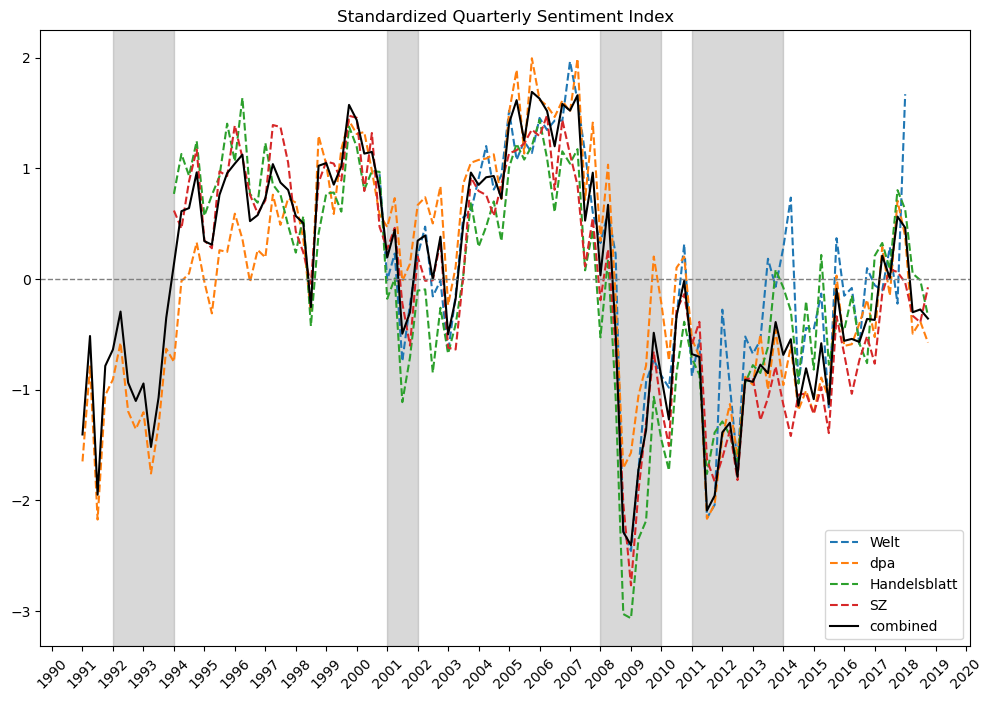

In [40]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a new figure
fig, ax = plt.subplots(figsize=(12, 8))

# Define the order of our series
order = ['sentiment_Welt', 'sentiment_dpa', 'sentiment_Handelsblatt', 'sentiment_SZ', 'sentiment_combined']

# Function to standardize a series (Z-score normalization)
def standardize(series):
    return (series - series.mean()) / series.std()

# Iterate through the sentiment series in defined order and plot each one
for key in order:
    
    sentiment = sentiments[key]
    
    # Convert 'quarter' column to integer, then to string
    sentiment['quarter'] = sentiment['quarter'].astype(int).astype(str)

    def convert_year_quarter(year, quarter):
        '''This function converts year and quarter into a valid date string'''
        # Map each quarter to its starting month
        quarter_start_month = {'1': '01', '2': '04', '3': '07', '4': '10'}
        return f'{year}-{quarter_start_month[quarter]}'

    # Apply the function to generate dates
    sentiment['date'] = sentiment.apply(lambda x: convert_year_quarter(str(x['year']), str(x['quarter'])), axis=1)

    # Convert the result into a datetime object
    dates = pd.to_datetime(sentiment['date'], format='%Y-%m', errors='coerce')

    # Standardize the sentiment index
    sentiment['standardized_sentiment'] = standardize(sentiment['sentiment_index'])

    # If the series is 'combined', use a solid black line, else use a dashed line
    if key == 'sentiment_combined':
        ax.plot(dates, sentiment['standardized_sentiment'], label=key.replace('sentiment_', ''), linestyle='solid', color='black')
    else:
        ax.plot(dates, sentiment['standardized_sentiment'], linestyle='dashed', label=key.replace('sentiment_', ''))

# Add a horizontal line at zero to indicate the standardized mean
ax.axhline(0, color='gray', linewidth=1, linestyle='--')

# Add title and labels
ax.set_title('Standardized Quarterly Sentiment Index')

# Add a legend to the plot
ax.legend()

# Define the shaded areas for recessions
recessions = [
    ("1992-01-01", "1993-12-31"),  # Post-reunification recession
    ("2001-01-01", "2001-12-31"),  # Dot-com recession
    ("2008-01-01", "2009-12-31"),  # Great Recession
    ("2011-01-01", "2013-12-31")   # European sovereign debt crisis
]

# Shade the recession periods
for start, end in recessions:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='grey', alpha=0.3)

# Format the x-axis for better readability
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Display the plot
plt.show()

### Monthly sentiment indices

In [41]:
# List of news sources
sources = ['combined', 'Welt', 'dpa', 'Handelsblatt', 'SZ']

# Start and end years for each source
years = {
    'combined': (1991, 2019),
    'Welt': (1999, 2019),
    'dpa': (1991, 2019),
    'Handelsblatt': (1994, 2019),
    'SZ': (1994, 2019)
}

# Initialize a dictionary to store sentiment series
sentiments = {}

for source in sources:
    # Set data to the whole DataFrame for 'combined', otherwise filter by source
    if source == 'combined':
        source_data = data
    else:
        source_data = data[data.source == source]

    # Compute sentiment index for each month within the specified year range
    sentiment = sentiment_index('month', source_data, source, start_year=years[source][0], end_year=years[source][1])

    # Reset index of resulting DataFrame
    sentiment.reset_index(inplace=True, drop=True)
    
    # Store sentiment series in the dictionary
    sentiments[f'sentiment_{source}'] = sentiment

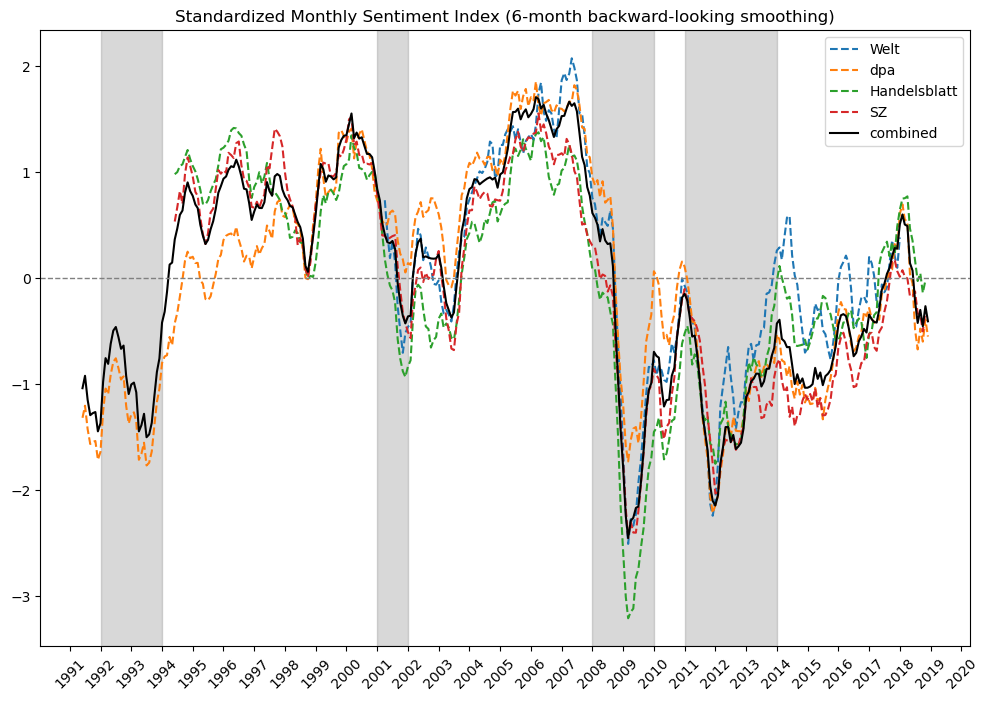

In [42]:
# Create a new figure
fig, ax = plt.subplots(figsize=(12, 8))

# Define the order of our series
order = ['sentiment_Welt', 'sentiment_dpa', 'sentiment_Handelsblatt', 'sentiment_SZ', 'sentiment_combined']

# Function to standardize a series (Z-score normalization)
def standardize(series):
    return (series - series.mean()) / series.std()

# Iterate through the sentiment series in defined order and plot each one
for key in order:
    
    sentiment = sentiments[key]
    
    # Convert 'month' column to integer, then to string
    sentiment['month'] = sentiment['month'].astype(int).astype(str)

    # Creating a date from the year and month
    dates = pd.to_datetime(sentiment['year'].astype(str) + '-' + sentiment['month'])

    # Apply a 6-month backward-looking rolling mean to smooth the series
    sentiment['smoothed_sentiment'] = sentiment['sentiment_index'].rolling(window=6).mean()

    # Standardize the smoothed series
    standardized_sentiment = standardize(sentiment['smoothed_sentiment'])

    # If the series is 'combined', use a solid black line, else use a dashed line
    if key == 'sentiment_combined':
        ax.plot(dates, standardized_sentiment, label=key.replace('sentiment_', ''), linestyle='solid', color='black')
    else:
        ax.plot(dates, standardized_sentiment, linestyle='dashed', label=key.replace('sentiment_', ''))

# Add a horizontal line at zero to indicate the standardized mean
ax.axhline(0, color='gray', linewidth=1, linestyle='--')

# Add title and labels
ax.set_title('Standardized Monthly Sentiment Index (6-month backward-looking smoothing)')

# Add a legend to the plot
ax.legend()

# Define the shaded areas for recessions
recessions = [
    ("1992-01-01", "1993-12-31"),  # Post-reunification recession
    ("2001-01-01", "2001-12-31"),  # Dot-com recession
    ("2008-01-01", "2009-12-31"),  # Great Recession
    ("2011-01-01", "2013-12-31")   # European sovereign debt crisis
]

# Shade the recession periods
for start, end in recessions:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='grey', alpha=0.3)

# Format the x-axis for better readability
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Display the plot
plt.show()

### Daily sentiment indices

In [43]:
# List of news sources
sources = ['combined', 'Welt', 'dpa', 'Handelsblatt', 'SZ']

# Start and end years for each source
years = {
    'combined': (1991, 2019),
    'Welt': (1999, 2019),
    'dpa': (1991, 2019),
    'Handelsblatt': (1994, 2019),
    'SZ': (1994, 2019)
}

# Initialize a dictionary to store sentiment series
sentiments = {}

for source in sources:
    # Set data to the whole DataFrame for 'combined', otherwise filter by source
    if source == 'combined':
        source_data = data
    else:
        source_data = data[data.source == source]

    # Compute sentiment index for each day within the specified year range
    sentiment = sentiment_index('day', source_data, source, start_year=years[source][0], end_year=years[source][1])

    # Reset index of resulting DataFrame
    sentiment.reset_index(inplace=True, drop=True)
    
    # Store sentiment series in the dictionary
    sentiments[f'sentiment_{source}'] = sentiment

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


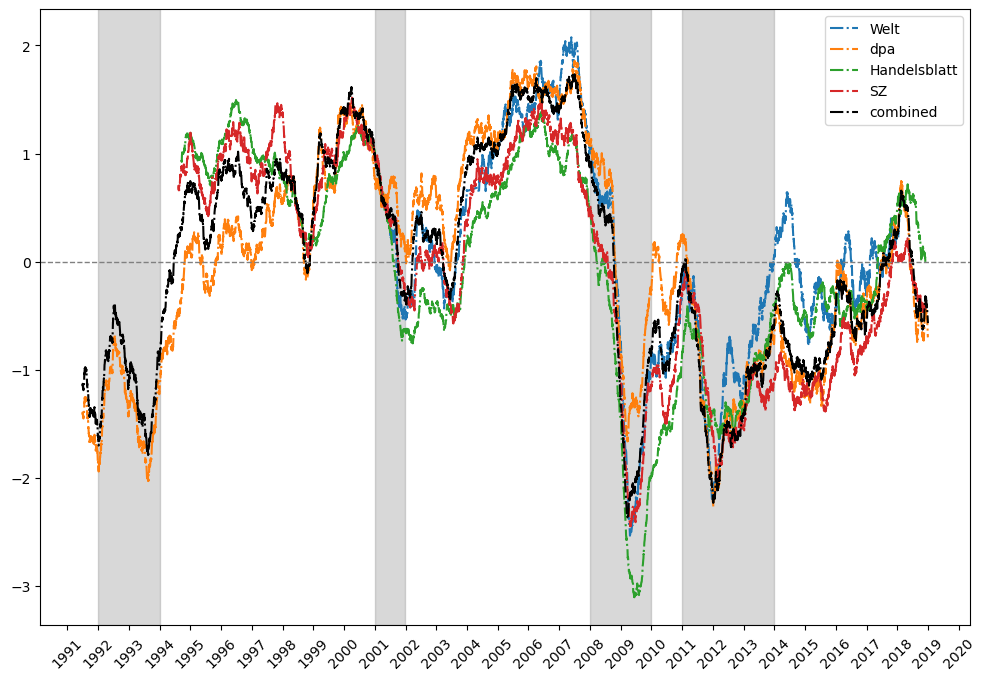

In [44]:
# Create a new figure
fig, ax = plt.subplots(figsize=(12, 8))

# Define the order of our series
order = ['sentiment_Welt', 'sentiment_dpa', 'sentiment_Handelsblatt', 'sentiment_SZ', 'sentiment_combined']

# Function to standardize a series (Z-score normalization)
def standardize(series):
    return (series - series.mean()) / series.std()

# Iterate through the sentiment series in defined order and plot each one
for key in order:
    sentiment = sentiments[key]

    # Convert 'year', 'month', 'day' columns to integer, then to string
    sentiment['year'] = sentiment['year'].astype(int).astype(str)
    sentiment['month'] = sentiment['month'].astype(int).astype(str)
    sentiment['day'] = sentiment['day'].astype(int).astype(str)

    # Creating a date from the year, month, and day
    dates = pd.to_datetime(sentiment['year'] + '-' + sentiment['month'] + '-' + sentiment['day'])

    # Calculate the rolling mean of the sentiment index
    rolling_mean = sentiment['sentiment_index'].rolling(window=180).mean() 

    # Standardize the rolling mean
    rolling_mean_standardized = standardize(rolling_mean)

    # Plot the standardized rolling mean series
    if key == 'sentiment_combined':
        # Make the 'sentiment_combined' series black
        ax.plot(dates, rolling_mean_standardized, label=key.replace('sentiment_', ''), color='black', linestyle='-.')
    else:
        # Plot the other series with default colors
        ax.plot(dates, rolling_mean_standardized, label=key.replace('sentiment_', ''), linestyle='-.')

# Add a horizontal line at zero to indicate the mean
ax.axhline(0, color='gray', linewidth=1, linestyle='--')

# Add a legend to the plot
ax.legend()

# Define the shaded areas for recessions
recessions = [
    ("1992-01-01", "1993-12-31"),  # Post-reunification recession
    ("2001-01-01", "2001-12-31"),  # Dot-com recession
    ("2008-01-01", "2009-12-31"),  # Great Recession
    ("2011-01-01", "2013-12-31")   # European sovereign debt crisis
]

# Shade the recession periods
for start, end in recessions:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='grey', alpha=0.3)

# Format the x-axis for better readability
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotate date labels for better visibility
plt.xticks(rotation=45)

plt.savefig('daily_sentiment_all_media_standardized.eps', format='eps')
plt.savefig('daily_sentiment_all_media_standardized.png', format='png')

# Display the plot
plt.show()